In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

import scipy.io as sc
from sklearn.metrics import mean_squared_error, r2_score

EMBEDDING_SIZE = 4

/var/folders/48/_wqpm7x9659b0t_zqycj5z200000gn/T/ipykernel_12230/321381744.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


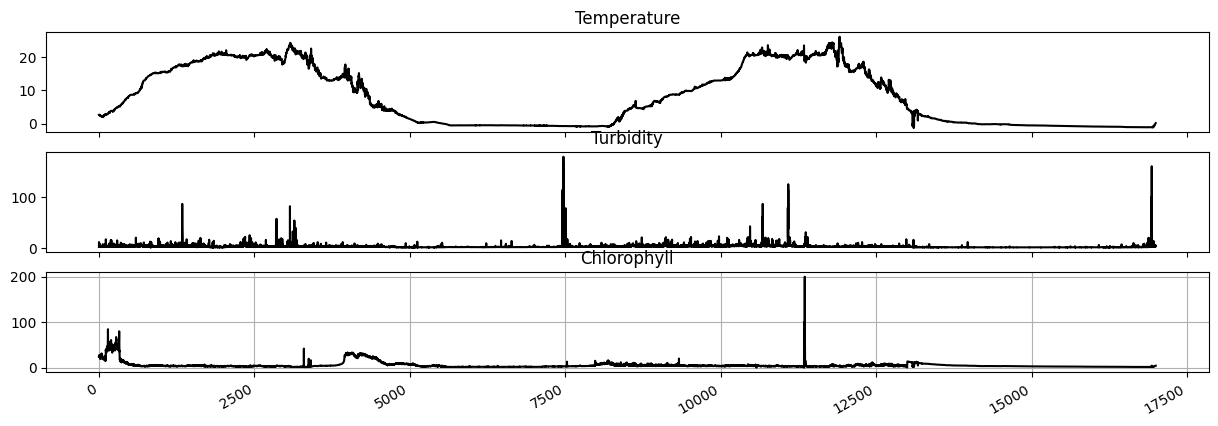

(16997, 4)


In [55]:
# download the data
f = sc.loadmat('data_new.mat')
vals = f['data_new'][0,0]
keys = f['data_new'][0,0].dtype.descr
f['data_new'][0,0]["Y"].shape

data = {}
for i in range(len(keys)-1):
    key = keys[i][0]
    data[str(key)] = vals[key]

datafrm = {"Temperature": data["X"][0,:].reshape(-1), "Turbidity": data["X"][1,:].reshape(-1), "Chlorophyll": data["X"][2,:].reshape(-1), "TargetChlorophyll": data["Y"].reshape(-1)}
data = pd.DataFrame(data=datafrm)

# visualize the data
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.subplot(3,1,1)
plt.plot(data["Temperature"],c='black')
plt.title("Temperature")

plt.subplot(3,1,2)
plt.plot(data["Turbidity"],c='black')
plt.title("Turbidity")

plt.subplot(3,1,3)
plt.plot(data["Chlorophyll"],c='black')
plt.title("Chlorophyll")

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
print(data.shape)

/var/folders/48/_wqpm7x9659b0t_zqycj5z200000gn/T/ipykernel_12230/240068689.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


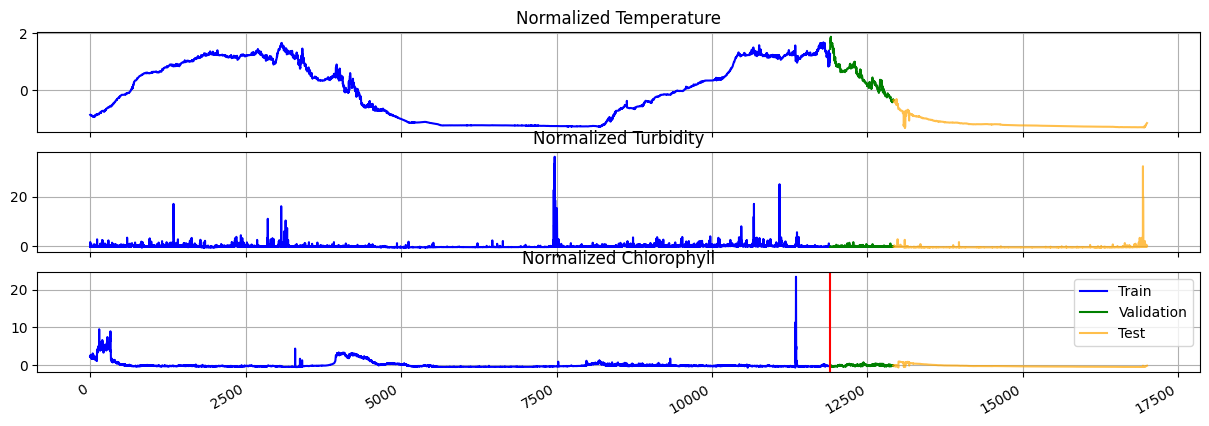

In [56]:

# split the data into train and test partitions, use 70% first samples as test data and rest as train data
Tp = 11900 # ≈70%
Tv = 1020 # ≈20% of the remaining
values = data.values.astype(np.float32)
train,test = values[0:Tp,:], values[Tp:,:]

# normalize the data, use train set normalization for test set
scaler = preprocessing.StandardScaler()
train_scaler = scaler.fit(train)
data_norm = train_scaler.transform(values).reshape(-1,4)

#data_norm = pd.DataFrame(data_norm, columns=["Value"])
# visualize the data again with test and training samples separated
index = data.index.values

plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))
plt.subplot(3,1,1)
plt.plot(index[0:Tp],data_norm[:Tp,0],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c='orange',alpha=0.7)
plt.title("Normalized Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(index[0:Tp],data_norm[:Tp,1],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c='orange',alpha=0.7)
plt.title("Normalized Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(index[0:Tp],data_norm[:Tp,2],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c='orange',alpha=0.7)
plt.legend(['Train','Validation', 'Test'])
plt.axvline(data.index[Tp], c="r")
plt.title("Normalized Chlorophyll")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()


In [57]:
step = EMBEDDING_SIZE

train_norm = data_norm[:Tp,:]
val_norm = data_norm[Tp:Tp+Tv,:]
test_norm = data_norm[Tp+Tv:,:]

# add step elements into train and test
test_norm = np.append(test_norm,np.repeat(test_norm[-1,:],step).reshape(-1,4).T, axis=0)
val_norm = np.append(val_norm,np.repeat(val_norm[-1,:],step).reshape(-1,4).T, axis=0)
train_norm = np.append(train_norm,np.repeat(train_norm[-1,:],step).reshape(-1,4).T, axis=0)

print("Train data length:", train_norm.shape)
print("Val data length:", val_norm.shape)
print("Test data length:", test_norm.shape)



Train data length: (11904, 4)
Val data length: (1024, 4)
Test data length: (4081, 4)


In [58]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,:3])
        Y.append(data[d-1,3])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train_norm,step)
valX,valY =convertToMatrix(val_norm,step)
testX,testY =convertToMatrix(test_norm,step)

#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
#valX = np.reshape(valX, (valX.shape[0], valX.shape[2], valX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Validation data shape:", valX.shape,', ',valY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (11900, 4, 3) ,  (11900,)
Validation data shape: (1020, 4, 3) ,  (1020,)
Test data shape: (4077, 4, 3) ,  (4077,)


In [59]:
def build_simple_rnn(num_units=128, embedding=EMBEDDING_SIZE,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(embedding,3), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

model = build_simple_rnn() # Taking the defaults
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 128)               16896     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [61]:
batch_size = 16
num_epochs = 50

model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],
          verbose=1,
          validation_data=(valX, valY))

Epoch 1/50
744/744 [==============================] - 1s 1ms/step - loss: 0.1034 - mse: 0.1034 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 2/50
744/744 [==============================] - 1s 960us/step - loss: 0.0883 - mse: 0.0883 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 3/50
744/744 [==============================] - 1s 873us/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/50
744/744 [==============================] - 1s 983us/step - loss: 0.0801 - mse: 0.0801 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 5/50
744/744 [==============================] - 1s 888us/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 6/50
744/744 [==============================] - 1s 844us/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 7/50
744/744 [==============================] - 1s 809us/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 8/50
744/744 [==============================] - 1s 811us/s

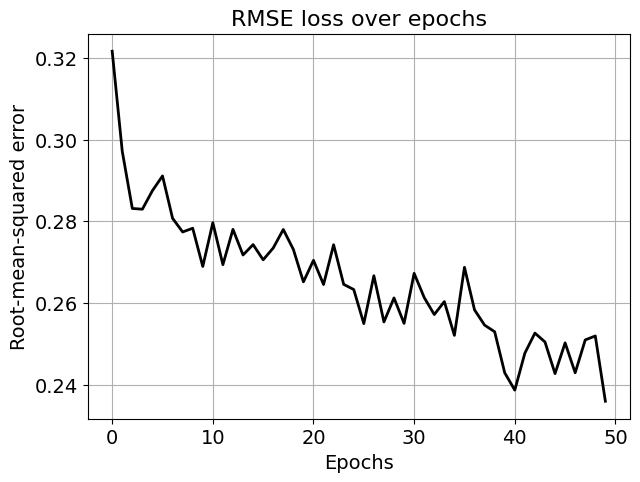

In [62]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [64]:

validation_target = testY
validation_predictions = []
last_x = trainX[-1,:,:]

testInd = 0
while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,4,3), verbose=1)[0,0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1, axis=0)

  last_x[-1,0] = testX[testInd,-1,0]
  last_x[-1,1] = testX[testInd,-1,1]
  last_x[-1,2] = p
  testInd = testInd + 1


1/1 [==============================] - 0s 10ms/step


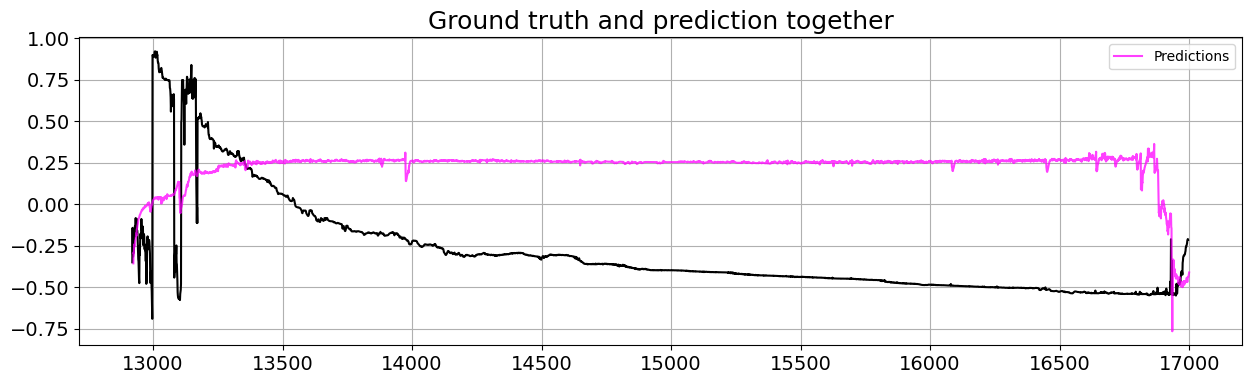

In [66]:
index = data.index.values
train_index = index[:Tp]
val_index = index[Tp:Tp+Tv]
test_index = index[Tp+Tv:]

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)

plt.plot(test_index, data_norm[test_index,-1],c='black')
#plt.plot(train_index+WINDOW_SIZE, train_results['Train Predictions'], c='orange',alpha=0.75)
#plt.plot(val_index+WINDOW_SIZE, val_results['Val Predictions'], c='blue',alpha=0.75)
plt.plot(test_index+EMBEDDING_SIZE, validation_predictions, c='magenta',alpha=0.75, label="Predictions")

plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()